## Import libraries

We will now implement deep Q-learning, from the [2015 paper](https://www.nature.com/articles/nature14236) paper of Mnih et al.

In [8]:
import gym
import numpy as np
import random
import math
%matplotlib inline
import matplotlib.pyplot as plt


env = gym.make('CartPole-v0')

low = env.observation_space.low
high=env.observation_space.high

input_dim  = env.observation_space.shape[0]
output_dim = env.action_space.n

discount_factor = 0.99 

### Import Keras and define the neural network

Now, instead of the Q-table, we will implement a neural network to approximate the Q-function.
The network will have the state of the environment as an input and the Q-values associated with each action as output.
Define a neural network with _inputdim_ input neurons, _outputdim_ output neurons and an hidden layer of 64 neurons. Use a ReLU activation function in the hidden layer and a linear one in the output layer.

In [9]:
import keras as K

model = K.Sequential()
model.add(K.layers.Dense(64, activation='relu', input_dim=input_dim))
model.add(K.layers.Dense(output_dim, activation='linear'))

opt = K.optimizers.Adam()
model.compile(loss='mse', optimizer=opt)

## Define the memory that we need to store the samples

For the algorithm to work, we need a memory to store many (state, action, reward, next_state) tuples, and then we will use them for the neural network training.
It strongly helps to sample a random batch of _batch_size_ samples from the memory, to avoid correlated samples during the training.

In [10]:
class Memory:
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)
    
capacity=100000
memory=Memory(capacity)

### Deep Q-network algorithm

To train the neural network, we need to work with a supervised learning approach. We want the neural network to approximate the optimal Q-function which is, following the Bellman equation:
$$Q^{new}(s_t,a_t)=Q^{old}(s_t,a_t)+\alpha (r_t+\gamma \underset{a}{max} Q^{old}(s_{t+1},a_t) -Q^{old}(s_t,a_t))$$
You can notice that the optimal Q-function is then:
$$Q^{*}(s_t,a_t)=r_t+\gamma \underset{a}{max} Q^{old}(s_{t+1},a_t)$$
<br>
So, for the training, you just need an x array containing each of the _batchsize_ samples, and an y array with all entry $Q^{old}(s_{0},a)$ except for the one corresponding to the action that the agent took, which will be $y[a]=r_t+\gamma \underset{a}{max} Q^{old}(s_{t+1},a_t)$

**Example**
If the first sample is ($s_0$, $a=1$, $r_0$, $s_1$), I will have:
$$ x[0]=s_0$$
$$ y[0]=[Q^{old}(s_{0},a=0), r_0+\gamma \underset{a}{max} Q^{old}(s_{1},a)]$$

You can estimate $Q^{old}(s,a)$ with the neural network.

In [11]:
batch_size = 64
discount_factor = 0.99

def DQN_update():    
    batch = memory.sample(batch_size)
    len_batch = len(batch)

    states = np.array([ o[0] for o in batch ])
    states_ = np.array([ (np.zeros(input_dim) if o[3] is None else o[3]) for o in batch ])

    prediction = model.predict(states)
    prediction_ = model.predict(states_)

    x, y =  np.zeros((len_batch, input_dim)), np.zeros((len_batch, output_dim))

    for i in range(len_batch):
        state = batch[i][0]; action = batch[i][1]; reward = batch[i][2]; state_ = batch[i][3]

        target = prediction[i]
        if state_ is None:
            target[action] = reward
        else:
            target[action] = reward + discount_factor * np.amax(prediction_[i])

        x[i]=state
        y[i]=target

    model.fit(x, y, batch_size=64, epochs=1, verbose=0)

### Define learning and exploration rates

In [12]:
min_eps=0.01 
max_eps=1 
gamma=0.02

def get_explore_rate(episode):
    return  min_eps + (max_eps - min_eps) * math.exp(-gamma * episode)

## Rule for selecting an action

This function is very similar to the Q-table case, but now you will predict the Q-values of each action by employing the _predict()_ function of your keras model.

In [13]:
def select_action(state, episode):
    explore_rate = get_explore_rate(episode)
    
    if random.random() < explore_rate:
        return env.action_space.sample()
    else:
        return np.argmax(model.predict(state.reshape(1,input_dim)))

## Simulation

In [14]:
max_episodes = 1000
max_t = 250
combo_goal = 100
timesteps_goal= 195

combo = 0
R=[]


for episode in range(max_episodes):
    state = env.reset()
    cumulative_reward = 0 
    for t in range(max_t):        
        #self.env.render()
        action = select_action(state, episode)
        next_state, reward, done, info = env.step(action)
        if done:
            if (t >= 150): 
                combo += 1
            else: 
                combo = 0
            next_state = None
        memory.add( (state, action, reward, next_state) )
        DQN_update()            
        state = next_state
        cumulative_reward += reward
        if done:
            break

    print('Episode: {}'.format(episode), 'Total reward: {}'.format(cumulative_reward))
    R.append(cumulative_reward)
    if combo > combo_goal:
        break

Episode: 0 Total reward: 15.0
Episode: 1 Total reward: 19.0
Episode: 2 Total reward: 10.0
Episode: 3 Total reward: 15.0
Episode: 4 Total reward: 12.0
Episode: 5 Total reward: 10.0
Episode: 6 Total reward: 18.0
Episode: 7 Total reward: 13.0
Episode: 8 Total reward: 21.0
Episode: 9 Total reward: 23.0
Episode: 10 Total reward: 14.0
Episode: 11 Total reward: 29.0
Episode: 12 Total reward: 41.0
Episode: 13 Total reward: 11.0
Episode: 14 Total reward: 8.0
Episode: 15 Total reward: 10.0
Episode: 16 Total reward: 12.0
Episode: 17 Total reward: 38.0
Episode: 18 Total reward: 21.0
Episode: 19 Total reward: 21.0
Episode: 20 Total reward: 31.0
Episode: 21 Total reward: 14.0
Episode: 22 Total reward: 11.0
Episode: 23 Total reward: 13.0
Episode: 24 Total reward: 12.0
Episode: 25 Total reward: 13.0
Episode: 26 Total reward: 16.0
Episode: 27 Total reward: 12.0
Episode: 28 Total reward: 13.0
Episode: 29 Total reward: 11.0
Episode: 30 Total reward: 18.0
Episode: 31 Total reward: 10.0
Episode: 32 Total r

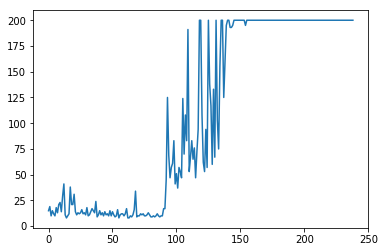

In [15]:
plt.plot(R)
plt.show()